## Reptile image classification with machine learning

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Checks to see if libraries are up to date and updates them if they are not

In [2]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.5 MB/s eta 0:00:0000:0100:01


## First we need to download images of different kinds of reptiles

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords,max_images=200):
    return L(DDGS().images(keywords,max_results=max_images)).itemgot("image")
import time, json

Testing to see if search returns proper results for "lizard"

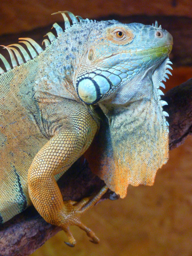

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images('lizard photos',max_images=1)[0],'lizard.jpg',show_progress=False)
im_lizard = Image.open('lizard.jpg')
im_lizard.to_thumb(256,256)


Now testing the same thing for "snake"

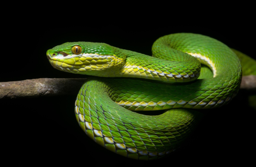

In [5]:
download_url(search_images('snake photos',max_images=1)[0],'snake.jpg',show_progress=False)
im_snake = Image.open('snake.jpg')
im_snake.to_thumb(256,256)

Searches give good results so now its time to collect more data. This time we will collect images of lizards, snakes, turtles, tortoises, alligators, and crocodiles

In [6]:
searches = "lizard","snake","tortoise","turtle","alligator","crocodile"
path = Path("which_reptile")

for i in searches:
    dest = (path/i)
    dest.mkdir(exist_ok=True,parents=True)
    download_images(dest,urls= search_images(f'{i} photo'))
    time.sleep(5)
    resize_images(path/i,max_size=400,dest=path/i)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Model Training

After collecting the image data it is now time to train the classification model

In [7]:
failed = verify_images(get_image_files(path)) 
failed.map(Path.unlink) #removes failed images
len(failed) #checks to see how many failed images

44

Next we need to create dataloaders object with training and validation data

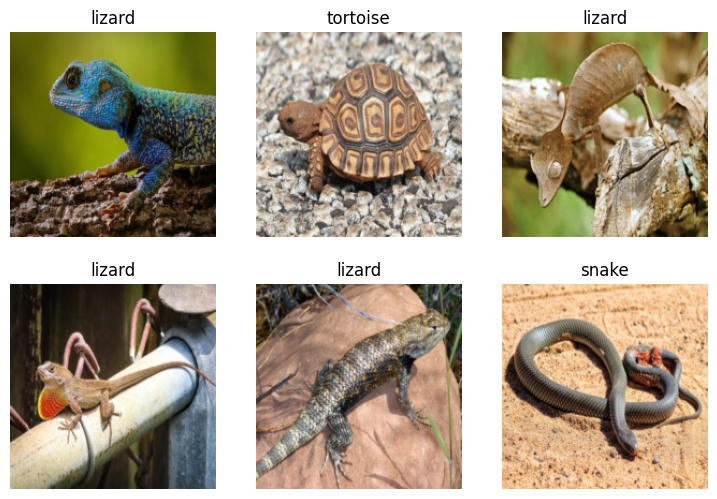

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now its time to train the model. I am using the Resnet18 model for image classification.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.869195,0.801268,0.267606,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.714922,0.825754,0.244131,00:02
1,0.526826,0.905134,0.253521,00:02
2,0.369639,0.860403,0.239437,00:02


## Applying the model

In [12]:
which_reptile,_,prob = learn.predict(PILImage.create('lizard.jpg'))
print(f"This is a {which_reptile}.")
print(f"Probability its a {which_reptile}: {prob[0]:.4f}")

This is a lizard.
Probability its a lizard: 0.0004
